In [2]:
import os
import pandas as pd
import numpy as np
from collections import Counter

# Visualization

import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
def spline(input):

    return abs(input)

def ReLu(input):
    return max(0.1*input,input)

In [4]:
class Neuron:

    def __init__(self,input,activation_type = "ReLu"):
       
       self.pre_layer = input
       self.value = self.output(self.pre_layer)
       self.activation = activation_type

    def output(self,input):
        
        '''
        Input : Value of nodes from previous layer
        sum : Adding together nodes after passing them through activation function (Bspline)

        '''
        # length = len(input)
        sum = 0
        for i in input:

            sum += spline(i)

        return sum

In [5]:
x = [-1,-2,-3,-4,-5,-6]

In [6]:
y = Neuron(x)

In [8]:
y.value

21

In [9]:
from scipy import interpolate

In [10]:
ctr =np.array( [(3 , 1), (2.5, 4), (0, 1), (-2.5, 4),
                (-3, 0), (-2.5, -4), (0, -1), (2.5, -4), (3, -1)])

x1=ctr[:,0]
y1=ctr[:,1]

In [11]:
# plt.plot(x1,y1,"ro")
plt.plot(out[0],out[1],"ro")

NameError: name 'out' is not defined

In [13]:

tck,u = interpolate.splprep([x1,y1],k=3,s=0)

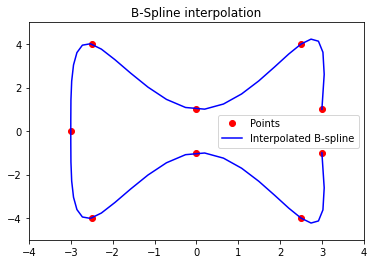

In [14]:
u=np.linspace(0,1,num=50,endpoint=True)
out = interpolate.splev(u,tck)

plt.figure()
plt.plot(x1, y1, 'ro', out[0], out[1], 'b')
plt.legend(['Points', 'Interpolated B-spline', 'True'],loc='best')
plt.axis([min(x1)-1, max(x1)+1, min(y1)-1, max(y1)+1])
plt.title('B-Spline interpolation')
plt.show()

In [27]:
import torch


def B_batch(x, grid, k=0, extend=True, device='cpu'):
    '''
    evaludate x on B-spline bases
    
    Args:
    -----
        x : 2D torch.tensor
            inputs, shape (number of splines, number of samples)
        grid : 2D torch.tensor
            grids, shape (number of splines, number of grid points)
        k : int
            the piecewise polynomial order of splines.
        extend : bool
            If True, k points are extended on both ends. If False, no extension (zero boundary condition). Default: True
        device : str
            devicde
    
    Returns:
    --------
        spline values : 3D torch.tensor
            shape (number of splines, number of B-spline bases (coeffcients), number of samples). The numbef of B-spline bases = number of grid points + k - 1.
      
    Example
    -------
    >>> num_spline = 5
    >>> num_sample = 100
    >>> num_grid_interval = 10
    >>> k = 3
    >>> x = torch.normal(0,1,size=(num_spline, num_sample))
    >>> grids = torch.einsum('i,j->ij', torch.ones(num_spline,), torch.linspace(-1,1,steps=num_grid_interval+1))
    >>> B_batch(x, grids, k=k).shape
    torch.Size([5, 13, 100])
    '''

    # x shape: (size, x); grid shape: (size, grid)
    def extend_grid(grid, k_extend=0):
        # pad k to left and right
        # grid shape: (batch, grid)
        h = (grid[:, [-1]] - grid[:, [0]]) / (grid.shape[1] - 1)

        for i in range(k_extend):
            grid = torch.cat([grid[:, [0]] - h, grid], dim=1)
            grid = torch.cat([grid, grid[:, [-1]] + h], dim=1)
        grid = grid.to(device)
        return grid

    if extend == True:
        grid = extend_grid(grid, k_extend=k)

    grid = grid.unsqueeze(dim=2).to(device)
    x = x.unsqueeze(dim=1).to(device)

    if k == 0:
        value = (x >= grid[:, :-1]) * (x < grid[:, 1:])
    else:
        B_km1 = B_batch(x[:, 0], grid=grid[:, :, 0], k=k - 1, extend=False, device=device)
        value = (x - grid[:, :-(k + 1)]) / (grid[:, k:-1] - grid[:, :-(k + 1)]) * B_km1[:, :-1] + (
                    grid[:, k + 1:] - x) / (grid[:, k + 1:] - grid[:, 1:(-k)]) * B_km1[:, 1:]
    return value

def coef2curve(x_eval, grid, coef, k, device="cpu"):
    '''
    converting B-spline coefficients to B-spline curves. Evaluate x on B-spline curves (summing up B_batch results over B-spline basis).
    
    Args:
    -----
        x_eval : 2D torch.tensor)
            shape (number of splines, number of samples)
        grid : 2D torch.tensor)
            shape (number of splines, number of grid points)
        coef : 2D torch.tensor)
            shape (number of splines, number of coef params). number of coef params = number of grid intervals + k
        k : int
            the piecewise polynomial order of splines.
        device : str
            devicde
        
    Returns:
    --------
        y_eval : 2D torch.tensor
            shape (number of splines, number of samples)
        
    Example
    -------
    >>> num_spline = 5
    >>> num_sample = 100
    >>> num_grid_interval = 10
    >>> k = 3
    >>> x_eval = torch.normal(0,1,size=(num_spline, num_sample))
    >>> grids = torch.einsum('i,j->ij', torch.ones(num_spline,), torch.linspace(-1,1,steps=num_grid_interval+1))
    >>> coef = torch.normal(0,1,size=(num_spline, num_grid_interval+k))
    >>> coef2curve(x_eval, grids, coef, k=k).shape
    torch.Size([5, 100])
    '''
    # x_eval: (size, batch), grid: (size, grid), coef: (size, coef)
    # coef: (size, coef), B_batch: (size, coef, batch), summer over coef
    if coef.dtype != x_eval.dtype:
        coef = coef.to(x_eval.dtype)
    y_eval = torch.einsum('ij,ijk->ik', coef, B_batch(x_eval, grid, k, device=device))
    return y_eval


def curve2coef(x_eval, y_eval, grid, k, device="cpu"):
    '''
    converting B-spline curves to B-spline coefficients using least squares.
    
    Args:
    -----
        x_eval : 2D torch.tensor
            shape (number of splines, number of samples)
        y_eval : 2D torch.tensor
            shape (number of splines, number of samples)
        grid : 2D torch.tensor
            shape (number of splines, number of grid points)
        k : int
            the piecewise polynomial order of splines.
        device : str
            devicde
        
    Example
    -------
    >>> num_spline = 5
    >>> num_sample = 100
    >>> num_grid_interval = 10
    >>> k = 3
    >>> x_eval = torch.normal(0,1,size=(num_spline, num_sample))
    >>> y_eval = torch.normal(0,1,size=(num_spline, num_sample))
    >>> grids = torch.einsum('i,j->ij', torch.ones(num_spline,), torch.linspace(-1,1,steps=num_grid_interval+1))
    torch.Size([5, 13])
    '''
    # x_eval: (size, batch); y_eval: (size, batch); grid: (size, grid); k: scalar
    mat = B_batch(x_eval, grid, k, device=device).permute(0, 2, 1)
    # coef = torch.linalg.lstsq(mat, y_eval.unsqueeze(dim=2)).solution[:, :, 0]
    coef = torch.linalg.lstsq(mat.to(device), y_eval.unsqueeze(dim=2).to(device),
                              driver='gelsy' if device == 'cpu' else 'gels').solution[:, :, 0]
    return coef.to(device)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

1. Each node in layer 1 will take combination of spline(input1) + spline(input2)
2. The numpber of splines for each input is equal to number of nodes in outer layer.
3. So for 2 inputer x1 -->  spline(x1,1) -------> node 1 (same node as below)
                            spline(x1,2) -------> node 2
                            spline(x1,3) -------> node 3 

                    x2 -->  spline(x2,1) -------> node 1
                            spline(x2,2) -------> node 2
                            spline(x2,3) -------> node 3
4. Further each spline is composite of grid points = grid intervals + 1.


Spline

1. A spline is composite of n curves. (basis function)
2. The values of these curve depend on no. grid points G and order of polynomial K
3. So for e.g, a cubic basis function k = 3 and G= 5, will have 7 basis functions.
4. These function will combine to form a single curve.
5. Now we can increase the grid points to add more curves in the same interval, thus increase granularity.

 phi(x) = Σ c_i * B_i(x) is th equation for a spline.

 1. Here i is the number of grids points
 2. B_i(x) is the function corresponding each i values.
 3. These multiple B_i(x) combine to form one spline.
 4. Each B_i will cover a certain interval of grid/control points.
 5. THe control points are coefficneicts c_i
 6. Therefore c_i = t0 + t1+ ...+ tn

In [29]:
num_spline = 5
num_sample = 100
num_grid_interval = 10
k = 3
x = torch.normal(0,1,size=(num_spline, num_sample))
grid = torch.einsum('i,j->ij', torch.ones(num_spline,), torch.linspace(-1,1,steps=num_grid_interval+1))
